# Problem 1: K-means clustering and image compression (3pts out of 15)

## Author: Markiian Novosad

#### The aim of this assignment is to understand the K-means clustering algorithm and how it is used for image compression. You will implement the algorithm and then use it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. Visually, the quality of the image does not deteriorate much for moderate $m$ and large enough $k$, while its size drops down significantly as we only have to store the $k$ centroids and the cluster allocations of the blocks


#### For this task of your homework you can get **3 points** plus extra (see the last part).

To do some preliminary reading about K-Means algorithm, please check the following links:
*   https://scikit-learn.org/stable/modules/clustering.html
*   https://towardsdatascience.com/image-compression-using-k-means-clustering-aa0c91bb0eeb


### Initialization

In [171]:
from PIL import Image
import requests
from io import BytesIO

url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

File Size In Bytes:- 2158570


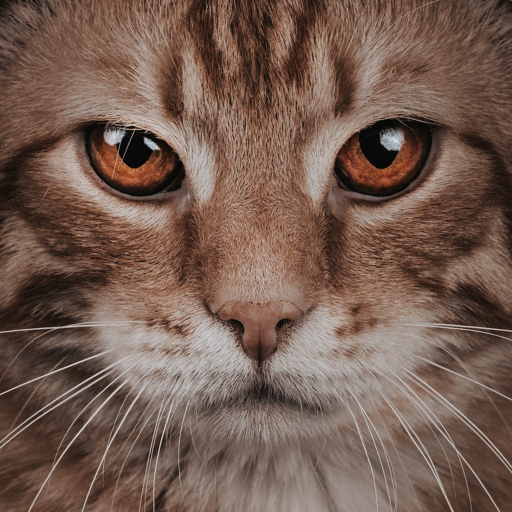

In [104]:
img

In [3]:
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [321]:
import numpy as np
from io import BytesIO

def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2,size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

def get_size_in_bytes(img: Image) -> int:
  img_file = BytesIO()
  img.save(img_file, 'png', quality='keep')
  return img_file.tell()

## 1. K-Means Clustering from scratch (1 pt)

In this part, you will have to implement K-Means clustering algorithm for a dataset of points in $\mathbb{R}^n$. To this end, you are asked to implement the following methods:

*   random centroid initialization (choose random dataset points) 
*   distance function
      *   Implement private methods with different distance metric (euclidian, l1, cosine, etc.)
*   allocation of points to clusters for given centroids
*   centroids update based on distance to all data points in respective clusters
*   and, finally, implement K-Means fitting loop, wich returns new fitted centroids





In [5]:
import random
import numpy as np
from scipy.spatial.distance import cdist

In [322]:
class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1, 
      max_iter=1000, 
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    assert (self.C) == X.shape[1]
    centroids = X[random.sample(range(X.shape[0]), self.K), :]
    return centroids


  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    return cdist(X, centroids, self.metric)

  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    dist = self.dist(X, centroids)
    return dist.argmin(-1)

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:

    mask = self.calc_mask(X, centroids)
    new_centroids = np.zeros_like(centroids)
    for i in np.sort(np.unique(mask)):
      new_centroids[i] = np.mean(X[np.where(mask == i)], axis=0)
    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def get_inertia(self, X: np.ndarray, centroids: np.ndarray) -> int:
    inertia = 0
    mask = self.calc_mask(X, centroids)
    for i in np.sort(np.unique(mask)):
      inertia += np.sum(np.power(cdist(X[np.where(mask == i)], [centroids[i]]), 2))
    return inertia

  def fit(self, X: np.ndarray) -> np.ndarray:
    centroids = self.init_centroids(X)
    for step in range(self.I):
      try:
        new_centroids = self.update_clusters(X, centroids)
        delta = np.linalg.norm(centroids - new_centroids)
        centroids = new_centroids
        print("#{} from {}. Delta {}".format(step + 1, self.I, delta))
        if delta < self.E:
          break
      except KeyboardInterrupt:
        print('Interrupted')
        break
    return centroids

## 2. Image compression using K-Means clustering (0.5 pt)
The dataset for clustering will be the $m\times m$ patches of the initial image. We split the image into patches with helper function **to_patches()**

In [301]:
m = 2 # size of patch
img = img.resize((512,512))
print("File Size In Bytes:- " + str(get_size_in_bytes(img)))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

File Size In Bytes:- 531533


(65536, 3, 2, 2)

Let's see how our splitted image looks:
(You can change padding from 0 to another value, to see the grid)

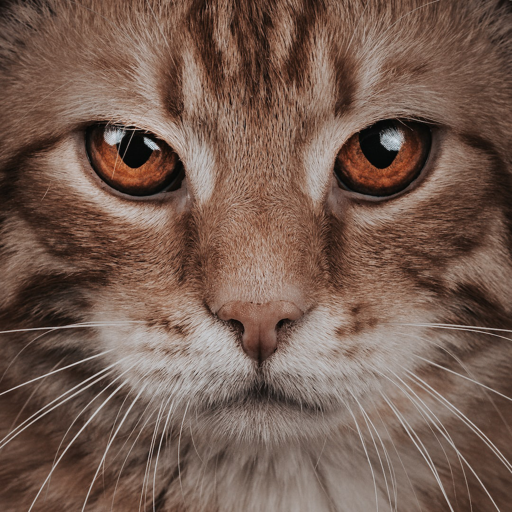

In [302]:
visualize_patches(patches, padding=0)

In [303]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(65536, 12)

## Try out your implementation!

In [319]:
# initialize KMeans algo
kmeans = KMeans(16, data.shape[-1], max_iter=400)
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)


#1 from 400. Delta 0.4034714698791504
#2 from 400. Delta 0.1585603952407837
#3 from 400. Delta 0.07624522596597672
#4 from 400. Delta 0.048936665058135986
#5 from 400. Delta 0.041758570820093155
#6 from 400. Delta 0.037791457027196884
#7 from 400. Delta 0.0352652408182621
#8 from 400. Delta 0.03396587446331978
#9 from 400. Delta 0.033335015177726746
#10 from 400. Delta 0.030674539506435394
#11 from 400. Delta 0.02623654529452324
#12 from 400. Delta 0.02340102568268776
#13 from 400. Delta 0.0207392368465662
#14 from 400. Delta 0.018554573878645897
#15 from 400. Delta 0.016390126198530197
#16 from 400. Delta 0.015524474903941154
#17 from 400. Delta 0.016144560649991035
#18 from 400. Delta 0.01610872708261013
#19 from 400. Delta 0.016999870538711548
#20 from 400. Delta 0.017167149111628532
#21 from 400. Delta 0.01583859696984291
#22 from 400. Delta 0.016294894739985466
#23 from 400. Delta 0.015668675303459167
#24 from 400. Delta 0.01509462483227253
#25 from 400. Delta 0.013935511931777
#2

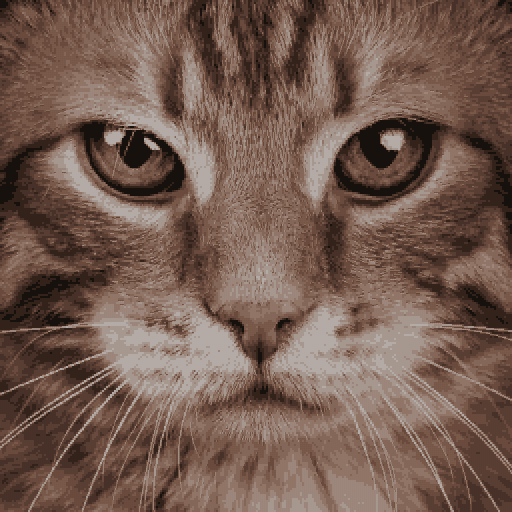

In [320]:
compressed_img = visualize_patches(predicted.reshape(-1,3,m,m))
compressed_img

## Task 2 (0.5 pt): Using the implemented image compression algorithm, discuss the following topics:
1.  **Distance Metrics**: how do they influence of distance metrics on final result of fitting? (Provide visualizations and comments)
2.  **Compression rate**: what is the compression rate with different **k** (1,2,...,32) and **m**? What compression rate can we achieve without losing much quality? 



1. Different distance metrics show-up unpredictably sometimes. For example, cosine and cityblock (manhattan) are below.\
I think, that cosine distance could be useful somehow, but not for our case. Because it sometimes gives as negative results (not applicable to images).\
We, otherwise, expect only positive numbers.
  a. ![cosine](./results/cosine-m2-128.png):
  b. ![cityblock](./results/cityblock-m2-128.png)
2. Compression rate:
  a. [m = 2, cluster_size = 16] From what we see, the picture is ok. It is noticeable that some details are missing, but the quality remains good (531kB to 86kB ~ 6x).\
  b. [m = 2, cluster_size = 128] (with higher m, the artifacts are visible) the looses are not even noticeable. So, let's take it as our best result (531kB to 166kB ~ 3.2x)
---

#1 from 300. Delta 0.5188434720039368
#2 from 300. Delta 0.22173884510993958
#3 from 300. Delta 0.1418135166168213
#4 from 300. Delta 0.11845000088214874
#5 from 300. Delta 0.10133129358291626
#6 from 300. Delta 0.09643607586622238
#7 from 300. Delta 0.07101134210824966
#8 from 300. Delta 0.050477057695388794
#9 from 300. Delta 0.041756175458431244
#10 from 300. Delta 0.03754217550158501
#11 from 300. Delta 0.03364803269505501
#12 from 300. Delta 0.03105400875210762
#13 from 300. Delta 0.031754326075315475
#14 from 300. Delta 0.031382814049720764
#15 from 300. Delta 0.03218593820929527
#16 from 300. Delta 0.03137599304318428
#17 from 300. Delta 0.03428974375128746
#18 from 300. Delta 0.03974028676748276
#19 from 300. Delta 0.03573489934206009
#20 from 300. Delta 0.03299272432923317
#21 from 300. Delta 0.032097917050123215
#22 from 300. Delta 0.03466922044754028
#23 from 300. Delta 0.04026152193546295
#24 from 300. Delta 0.04165395349264145
#25 from 300. Delta 0.043470513075590134
#26 f

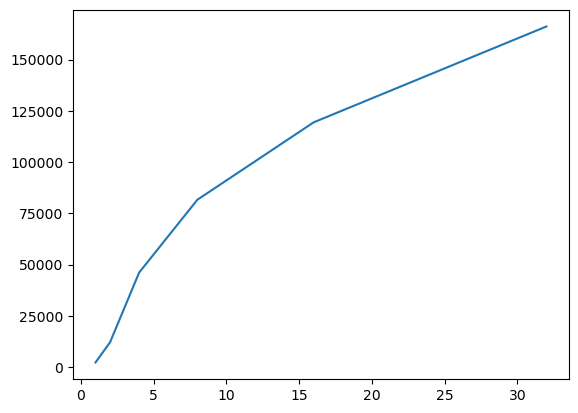

In [253]:
#Let's compare compression rates for different k values
import matplotlib.pyplot as plt

cluster_sizes = [32, 16, 8, 4, 2, 1]

image_sizes = np.zeros(6)
for k in range(len(cluster_sizes)):
  kmeans = KMeans(cluster_sizes[k], data.shape[-1], max_iter=300)
  centroids = kmeans.fit(data)
  predicted = kmeans.predict(data, centroids)
  compressed_img = visualize_patches(predicted.reshape(-1,3,m,m))
  image_sizes[k] = get_size_in_bytes(compressed_img)

plt.plot(cluster_sizes, image_sizes)

## 3. Elbow method (1 pt)

In this task, we will use the Elbow method to visualize the trade-off between quality and number of clusters **k** and try to select the best one!

##### To do some preliminary reading about Elbow Method, please, check the following link:
- https://stackabuse.com/k-means-clustering-with-the-elbow-method/

### Task 3: Implementation (0.3 pt)
Here we will implement the calculation of **Distortion** or **Inertia**, which are basically squared distances from each point to its assigned centroid. 

In [306]:
## For each k run clustering algorithm and compute it's Distortion value
k = cluster_sizes

def calc_distortion(data: np.ndarray, centroids:np.ndarray) -> float:
    distortion = 0
    # ========= YOUR CODE STARTS HERE ========= #
    mask = cdist(data, centroids).argmin(-1)
    for i in np.sort(np.unique(mask)):
      distortion += np.sum(np.power(cdist(data[np.where(mask == i)], [centroids[i]]), 2))
    # ========== YOUR CODE ENDS HERE ========== #
    return distortion

calc_distortion(data, centroids)

925.2431970515173

In [307]:
kmeans.get_inertia(data, centroids)

925.2431970515173

### Task 4: Calculate & Visualize (0.4 pt)
Let's use above implemented function to calculate distortion for some **k** values and visualize our results

#1 from 400. Delta 0.38939207792282104
#2 from 400. Delta 0.09448738396167755
#3 from 400. Delta 0.056838635355234146
#4 from 400. Delta 0.03476666286587715
#5 from 400. Delta 0.021552015095949173
#6 from 400. Delta 0.014744900166988373
#7 from 400. Delta 0.009900517761707306
#8 from 400. Delta 0.0060482751578092575
#9 from 400. Delta 0.004070394206792116
#10 from 400. Delta 0.0026207149494439363
#11 from 400. Delta 0.0014591192593798041
#12 from 400. Delta 0.0011583323357626796
#13 from 400. Delta 0.0011413578176870942
#14 from 400. Delta 0.0007801201427355409
#15 from 400. Delta 0.0004030507989227772
#16 from 400. Delta 0.0002199335431214422
#17 from 400. Delta 0.00018111462122760713
#18 from 400. Delta 9.028770728036761e-05
#19 from 400. Delta 5.407486969488673e-05
#20 from 400. Delta 0.0
#1 from 400. Delta 0.28929635882377625
#2 from 400. Delta 0.07133186608552933
#3 from 400. Delta 0.03853527083992958
#4 from 400. Delta 0.02385246567428112
#5 from 400. Delta 0.016330650076270103
#

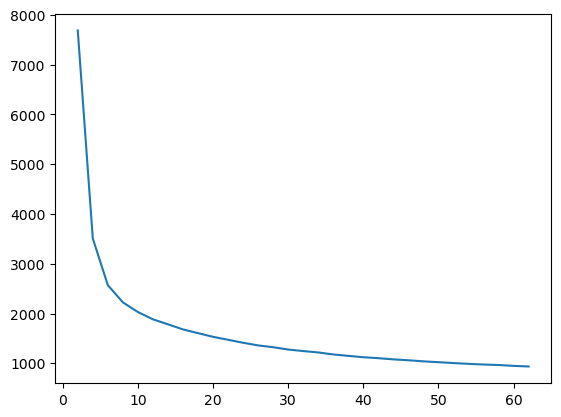

In [308]:
# You can choose your own values for the range 
#(it may take some time to run the loop, so feel free to optimize your code ;=) 
k_min = 2
k_max = 64
k_range = range(k_min, k_max, 2)

distortions = list()
#calculate distortion values
for k in k_range:
  # ========= YOUR CODE STARTS HERE ========= #
  kmeans = KMeans(k, data.shape[-1], max_iter=400)
  centroids = kmeans.fit(data)
  predicted = kmeans.predict(data, centroids)
  distortions.append(kmeans.get_inertia(data, centroids))
  # ========== YOUR CODE ENDS HERE ========== #

# Plot your results
# ========= YOUR CODE STARTS HERE ========= #
plt.plot(list(k_range), distortions)
# ========== YOUR CODE ENDS HERE ========== #

### Task 5: Summarize (0.3 pt)

Discuss your results: what is the best trade-off between number of clusters and distortion? 

What is the compression rate with this optimal value?

--- 

![elbow](./results/elbow.png)

In order to find the best trade of in details, we should maximize this pink distance and take number of clusters respectively to it.\
![optimal](./results/default-m2-16.png)
That is the optimal one.

From my perspective, the image is not so colorful. It could be influenced by the random start centroid point selection.\
Since our image has mainly gray-dark colours, the chance to receive the centroid-cluster with dark colours is high.

So, from the aesthetic perspective, I'd choose a bit higher cluster size. Let's say 32.

---

## 4. Conclusions (0.5 pt)

---

### Task 6 (0.5 pt)
Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment

---


I really enjoyed this task.
All the things were new to me from the general idea of K-means to Elbow method (how to find the optimal number of clusters).\
Probably, that's why it took me like ~16 hours to complete the task.

From what I see, there are some areas for improvements:
- Replace random centroids initialization with a smarter one. I think we should find the combination of centroids with the higher distances between them.
- Probably, there is a way to imporove some calculations, especially this one:
  ```
    for i in np.sort(np.unique(mask)):
    new_centroids[i] = np.mean(X[np.where(mask == i)], axis=0)
  ```

### **Bonus Problem** (0.5 pt)
Besides compression, K-Means clustering can be used in more "creative" way -- using bigger patch sizes we can create cool "pop-art" mosaics :=)

*Hint*: you can replace fitted centroids with your own patches. 

In [ ]:
# ========= YOUR CODE STARTS HERE ========= #

# ========== YOUR CODE ENDS HERE ========== #